<a href="https://colab.research.google.com/github/anubhavgupta1/Udacity/blob/main/Frameworks/Pytorch/DNNs/Cuda%20Support/MINIST%20Data%20GELU/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns
import time
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs
import keras
import torch

In [2]:
torch.manual_seed(0)

## Generate Dataset

In [3]:
(X_train, Y_train), (X_val, Y_val) = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
X_train,X_val = X_train.reshape(X_train.shape[0],28*28), X_val.reshape(X_val.shape[0],28*28)

In [5]:
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


## Using torch tensors and autograd

In [6]:
X_train, Y_train, X_val, Y_val = map(torch.tensor, (X_train, Y_train, X_val, Y_val))

In [7]:
print(X_train.shape, Y_train.shape)

torch.Size([60000, 784]) torch.Size([60000])


## GPU Configure

In [8]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
gpu = torch.device('cuda:0')


1
Tesla T4


In [9]:
X_train, Y_train, X_val, Y_val = X_train.float(), Y_train.long(), X_val.float(), Y_val.long()

In [10]:
X_train, Y_train, X_val, Y_val = X_train.to(gpu), Y_train.to(gpu), X_val.to(gpu), Y_val.to(gpu)

## Model Class

In [11]:
import torch.nn.functional as F
import torch.nn as nn
from torch import optim

In [12]:
class Mnist(nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.net = nn.Sequential(
        nn.Linear(784, 100), 
        nn.GELU(), 
        nn.Linear(100, 200), 
        nn.GELU(),
        nn.Linear(200, 300),
        nn.GELU(), 
        nn.Linear(300, 10),
        nn.Softmax()
    )

  def predict(self, X):
    return self.net(X)
  
  def accuracy(self, y_hat, y):
    pred_labels = torch.argmax(y_hat, dim=1)
    pred_binary = (pred_labels == y).float()
    average_acc = pred_binary.mean()
    return  average_acc
  
  def fit(self,X,Y,epochs = 1000, learning_rate = 1):
    loss_arr = []
    acc_arr  = []
    opt = optim.SGD(self.parameters(), lr=learning_rate)

    for epoch in range(epochs):
      Y_hat = self.predict(X)
      
      loss =  F.cross_entropy(Y_hat, Y)
      loss.backward()
      loss_arr.append(loss.item())
      
      acc = self.accuracy(Y_hat, Y)
      acc_arr.append(acc.item())
      
      opt.step()
      opt.zero_grad()

    plt.plot(loss_arr, 'r-')
    plt.plot(acc_arr, 'b-')
    plt.show()
    
    print('Loss before training', loss_arr[0])
    print('Loss after training', loss_arr[-1])
    return loss_arr, acc_arr

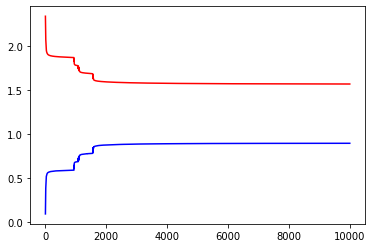

Loss before training 2.3352177143096924
Loss after training 1.5662318468093872
CPU times: user 2min 23s, sys: 1min 45s, total: 4min 8s
Wall time: 4min 9s


In [13]:
%%time
model = Mnist()
model = model.to(gpu)
loss, acc = model.fit(X_train,Y_train,epochs=10000, learning_rate=0.01)

In [14]:
Y_pred = model.predict(X_val)
test_acc = model.accuracy(Y_pred,Y_val)

In [15]:
print("Training accuracy is : ", acc[-1])
print("Test accuracy is : ", test_acc.item())

Training accuracy is :  0.8935333490371704
Test accuracy is :  0.8795999884605408
